### Dependencies

In [1]:
def get_f_period(p_date,f_date):
    d = pd.to_datetime(p_date) - pd.to_datetime(f_date)
    return d.days * 24  + d.seconds // 3600

import os 
import pickle
import pandas as pd
import numpy as np

### Load Data 
- Last Measurements (from 01/03/2021)
- Last 5 months of Forecasts

In [2]:
# Measurements
measurement_out = pd.read_csv('../data/processed/last_measurement_from_202001.csv')
measurement_out['datetime'] = measurement_out['datetime'].map(lambda x : pd.to_datetime(x)) 
# Forecasts
forecast = pd.read_csv('../data/processed/last_forecast_from_202101.csv')
forecast['f_date'] = forecast['f_date'].map(lambda x : pd.to_datetime(x))
forecast['p_date'] = forecast['p_date'].map(lambda x : pd.to_datetime(x))
forecast['file_creation_date'] = forecast['file_creation_date'].map(lambda x : pd.to_datetime(x))

### Data Processing
- Shift measurements to get 49 lag
- Data Merge 
- Keep last forecasts

In [3]:
### Data Merge ###

# Save a copy of measurements to score results
Y_real = measurement_out.copy()

# 49 lag of measurements horizontal stack 
df_out = Y_real.add_suffix('_t-0')
for i in range(1, 49):
    df_temp = Y_real.copy().add_suffix('_t-'+str(i))
    df_out = pd.concat([df_out,df_temp.shift(i)],axis=1)
df_out = df_out.dropna(how='any')
#display(df_out.head(1))

# join measurements & forecast
df_joined = df_out.copy()
df_joined = df_joined.merge(forecast.add_suffix('_forecast'),
                 how='left',
                 left_on = 'datetime_t-0',
                 right_on='f_date_forecast')

# filter forecast files created after prediction time (same as crop out f_period > 7)
df_joined = df_joined.loc[df_joined['datetime_t-0'] >= df_joined['file_creation_date_forecast'],]


# Compute f_period
df_joined['f_period'] = df_joined[['datetime_t-0','p_date_forecast']] \
                         .apply(lambda row : get_f_period(row['datetime_t-0'],row['p_date_forecast']),axis=1)

# assert that file_creation_date_forecast is doing the job
assert((df_joined.f_period > 7).any()) 

# keep last forecast
df_joined = df_joined.groupby('datetime_t-0')['f_period'].min().reset_index() \
             .merge(df_joined,how='left')
    
# compute cos day and hour 
df_joined['cos_day'] = np.cos(2 * np.pi * df_joined['datetime_t-0'].dt.day / 365)
df_joined['cos_hour'] =  np.cos(2 * np.pi * df_joined['datetime_t-0'].dt.hour / 24)
#display(df_joined.head(1))

In [4]:
# Filter on 2020 data
df_joined = df_joined.loc[df_joined['datetime_t-0'].map(lambda x : str(x)[0:4] == '2020'),:]

In [14]:
import sys
sys.path.append('../utils/util_functions.py')

In [16]:
from utils.util_functions import *

### New models adjustements
- Compute forecast scenario & Dangerous
- Rename f_period -> f_period_forecast

In [17]:
# Compute needed columns for updated models
def get_int_scenario(speed, cos, sin):
    if is_S1(speed, cos, sin):
        return 1
    elif is_S2(speed, cos, sin):
        return 2
    elif is_S2b(speed, cos, sin):
        return 3
    elif is_S3(speed, cos, sin):
        return 4
    elif is_S3b(speed, cos, sin):
        return 5
    elif is_S4(speed, cos, sin):
        return 6
    return np.nan

import sys
sys.path.append('../')
#from utils.ui import *

df_joined['scenario_forecast'] = df_joined.apply(lambda row : get_int_scenario(row['speed_forecast'],
                                             row['cos_wind_dir_forecast'],
                                             row['sin_wind_dir_forecast']),
                  axis=1)

df_joined['dangerous_forecast'] = (df_joined['scenario_forecast'] > 3 ).map(int)

df_joined = df_joined.rename(columns={'f_period':'f_period_forecast'})

In [18]:
x1 = df_joined.apply(lambda row : is_S1(row['speed_forecast'],
                                             row['cos_wind_dir_forecast'],
                                             row['sin_wind_dir_forecast']),
                  axis=1)

In [19]:
x2 = df_joined.apply(lambda row : is_S2(row['speed_forecast'],
                                             row['cos_wind_dir_forecast'],
                                             row['sin_wind_dir_forecast']),
                  axis=1)

In [20]:
x3 = df_joined.apply(lambda row : is_S2b(row['speed_forecast'],
                                             row['cos_wind_dir_forecast'],
                                             row['sin_wind_dir_forecast']),
                  axis=1)

In [21]:
x4 = df_joined.apply(lambda row : is_S3(row['speed_forecast'],
                                             row['cos_wind_dir_forecast'],
                                             row['sin_wind_dir_forecast']),
                  axis=1)

In [22]:
x5 = df_joined.apply(lambda row : is_S3b(row['speed_forecast'],
                                             row['cos_wind_dir_forecast'],
                                             row['sin_wind_dir_forecast']),
                  axis=1)

In [23]:
x6 = df_joined.apply(lambda row : is_S4(row['speed_forecast'],
                                             row['cos_wind_dir_forecast'],
                                             row['sin_wind_dir_forecast']),
                  axis=1)

In [24]:
def get_angle_in_degree(cos, sin):
    #check if cos within reasonable range: 
    if (cos>=-1) & (cos <=1): 
        angle = 360 * np.arccos(cos) / (2*np.pi)
        if sin < 0:
            angle = 360 - angle
    #check if sin within reasonable range:       
    elif (sin>=-1) & (sin <=1):
        angle = 360 * np.arcsin(sin) / (2*np.pi)
        if cos < 0:
            angle = 180 - angle
        if angle < 0:
            angle += 360
    else:
        angle=0 
        #print('cos and sin out of range, returned 0')
    #because we care about the reverse angle for the scenarios
    return angle #(angle + 180) % 360

In [25]:
print((df_joined.loc[1372,'speed_forecast'],
 df_joined.loc[1372,'wind_dir_forecast'],
get_angle_in_degree(df_joined.loc[1372,'cos_wind_dir_forecast'],
                    df_joined.loc[1372,'sin_wind_dir_forecast'])))

(is_S3b(df_joined.loc[1372,'speed_forecast'],
     df_joined.loc[1372,'cos_wind_dir_forecast'],
       df_joined.loc[1372,'sin_wind_dir_forecast']),
 is_S4(df_joined.loc[1372,'speed_forecast'],
     df_joined.loc[1372,'cos_wind_dir_forecast'],
       df_joined.loc[1372,'sin_wind_dir_forecast']))

(0.3, 188.0, 187.99999999999997)


(True, True)

In [26]:
print((df_joined.loc[6954,'speed_forecast'],
 df_joined.loc[6954,'wind_dir_forecast'],
get_angle_in_degree(df_joined.loc[6954,'cos_wind_dir_forecast'],
                    df_joined.loc[6954,'sin_wind_dir_forecast'])))

(is_S2(df_joined.loc[6954,'speed_forecast'],
     df_joined.loc[6954,'cos_wind_dir_forecast'],
       df_joined.loc[6954,'sin_wind_dir_forecast']),
 is_S2b(df_joined.loc[6954,'speed_forecast'],
     df_joined.loc[6954,'cos_wind_dir_forecast'],
       df_joined.loc[6954,'sin_wind_dir_forecast']))

(2.0, 218.0, 217.99999999999994)


(True, True)

In [27]:
df_joined.loc[[76,77],['datetime_t-0','speed_forecast','wind_dir_forecast','scenario_legacy_forecast']]

,datetime_t-0,speed_forecast,wind_dir_forecast,scenario_legacy_forecast
76,2020-01-06 05:00:00,2.0,129.0,S2
77,2020-01-06 06:00:00,2.0,129.0,S2b


In [28]:
test = pd.DataFrame([x1,x2,x3,x4,x5,x6]).transpose()
test['sum'] = test.sum(axis=1)

test.loc[1372]

0      False
1      False
2      False
3      False
4       True
5       True
sum        2
Name: 1372, dtype: object

### Make predictions
- Load all models (regression & classification
- Merge predictions : model_feature_lag (prediction date is shifted to align with measurement t-0)

In [29]:
# To render results on app we need a branch here for datetime shift ###
from datetime import timedelta

# Load needed columns for all models 
columns_names = list(pd.read_csv('../models_09072021/column_names.csv')['0'])

# Loop lists
model_names = ['xgb','dt','mlp','rf']
features = ['speed','cos_wind_dir','sin_wind_dir','scenario','dangerous']
pred_periods = ['1','2','3']


models = dict()
for model_name in model_names:
    for feature in features:
        for pred_period in pred_periods:
            x = '_'.join([model_name,feature,pred_period])
            # Load model
            models[x] = pickle.load(open('../models_09072021/trained_models/' + x + '.pkl','rb'))
            df_temp = df_joined[['datetime_t-0']].copy()
            # Shift date
            df_temp['datetime_t-0'] = df_temp['datetime_t-0'] + timedelta(hours=int(pred_period))
            # Predict
            df_temp[x] = models[x].predict(df_joined[columns_names])
            # Save
            df_joined = df_joined.merge(df_temp,how='left')
            del df_temp            


### Compute ensemble models columns
 - Proba for scenario (6 columns) and binary (2 columns) classifications

In [30]:
# Scenario clasffication
for model_name in ['xgb','dt','mlp']:
    feature = 'scenario'
    for pred_period in pred_periods:
        x = '_'.join([model_name,feature,pred_period])
        print(x)
        # Shift date
        df_temp = df_joined[['datetime_t-0']].copy()
        df_temp['datetime_t-0'] = df_temp['datetime_t-0'] + timedelta(hours=int(pred_period))
        # Get 6 columns predictions (proba)
        df_temp[[x + '_p' + str(i) for i in range(1,7)]] = pd.DataFrame(models[x].predict_proba(df_joined[columns_names]),
                                                                        columns=[x + '_p' + str(i) for i in range(1,7)])
        # Save
        df_joined = df_joined.merge(df_temp,how='left')
        del df_temp        
    
# Binary classification
for model_name in ['xgb','dt','mlp','rf']:
    feature = 'dangerous'
    for pred_period in pred_periods:
        x = '_'.join([model_name,feature,pred_period])
        # Shift date
        df_temp = df_joined[['datetime_t-0']].copy()
        df_temp['datetime_t-0'] = df_temp['datetime_t-0'] + timedelta(hours=int(pred_period))
        # Get 6 columns predictions (proba)
        df_temp[[x + '_p' + str(i) for i in range(0,2)]] = pd.DataFrame(models[x].predict_proba(df_joined[columns_names]),
                                                                        columns=[x + '_p' + str(i) for i in range(0,2)])
        # Save
        df_joined = df_joined.merge(df_temp,how='left')
        del df_temp

xgb_scenario_1
xgb_scenario_2
xgb_scenario_3
dt_scenario_1
dt_scenario_2
dt_scenario_3
mlp_scenario_1
mlp_scenario_2
mlp_scenario_3


In [31]:
# Drop missing values (at least the 3 first rows)
df_joined = df_joined.dropna()
df_joined.shape

(8732, 546)

### Speed regression mae

In [32]:
from sklearn.metrics import mean_absolute_error

### Speed Mae ###
print('Model   1   2   3')
for model in ['xgb','rf','dt','mlp']:
    print(model,
          round(mean_absolute_error(df_joined['speed_t-0'],df_joined[model + '_speed_1']),2),
          round(mean_absolute_error(df_joined['speed_t-0'],df_joined[model + '_speed_2']),2),
          round(mean_absolute_error(df_joined['speed_t-0'],df_joined[model + '_speed_3']),2)
         )
print('Numtech' , round(mean_absolute_error(df_joined['speed_t-0'],df_joined['speed_forecast']),2))

Model   1   2   3
xgb 0.49 0.68 0.83
rf 0.54 0.75 0.91
dt 0.55 0.77 0.93
mlp 0.57 0.77 0.87
Numtech 1.0


### Wind Direction Regression Mae

In [33]:
def get_angle_in_degree(cos, sin):
    #check if cos within reasonable range: 
    if (cos>=-1) & (cos <=1): 
        angle = 360 * np.arccos(cos) / (2*np.pi)
        if sin < 0:
            angle = 360 - angle
    #check if sin within reasonable range:       
    elif (sin>=-1) & (sin <=1):
        angle = 360 * np.arcsin(sin) / (2*np.pi)
        if cos < 0:
            angle = 180 - angle
        if angle < 0:
            angle += 360
    else:
        angle=0 
        #print('cos and sin out of range, returned 0')
    #because we care about the reverse angle for the scenarios
    return angle #(angle + 180) % 360

def angle_diff(x):
    if x <= 180:
        return x 
    else:
        return 360-180
    

### Real wind dir ###
df_joined['wind_dir_t-0'] =  df_joined.apply(lambda row : get_angle_in_degree(row['cos_wind_dir_t-0'],
                                                                              row['sin_wind_dir_t-0']),
                                             axis=1)
    
for model_name in model_names:
    for pred_period in pred_periods:
        input_cos = model_name + '_cos_wind_dir_' + pred_period
        input_sin = model_name + '_sin_wind_dir_' + pred_period
        output_wind_dir = model_name + '_wind_dir_' + pred_period
        df_joined[output_wind_dir] =  df_joined.apply(lambda row : get_angle_in_degree(row[input_cos],row[input_sin]),axis=1)
        
print('Model  1  2  3')
for model_name in model_names:
    print(model_name,
          round((df_joined[model_name + '_wind_dir_1'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean()),
          round((df_joined[model_name + '_wind_dir_2'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean()),
          round((df_joined[model_name + '_wind_dir_3'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean())
         )
print("Numtech ",round((df_joined['wind_dir_forecast'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean()))

Model  1  2  3
xgb 16 24 31
dt 19 26 34
mlp 19 25 30
rf 17 25 32
Numtech  41


In [35]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 5.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


### Confusion Matrix 

In [36]:
# Real scenario & dangerous #
df_joined['scenario_t-0'] = df_joined.apply(lambda row : get_int_scenario(row['speed_t-0'],
                                                                          row['cos_wind_dir_t-0'],
                                                                          row['sin_wind_dir_t-0']),
                                                    axis=1)
df_joined['dangerous_t-0'] = (df_joined['scenario_t-0'] > 3).map(int)


# Regression scenario & dangerous
for model_name in model_names:
    for pred_period in pred_periods:
        
        input_speed =  model_name + '_speed_' + pred_period
        input_cos = model_name + '_cos_wind_dir_' + pred_period
        input_sin = model_name + '_sin_wind_dir_' + pred_period
        output_scenario = model_name + '_regression_scenario_' + pred_period
        output_dangerous = model_name + '_regression_dangerous_' + pred_period
        
        df_joined[output_scenario] = df_joined.apply(lambda row : get_int_scenario(row[input_speed],
                                                                                   row[input_cos],
                                                                                   row[input_sin]),
                                                    axis=1)
        df_joined[output_dangerous] = (df_joined[output_scenario] > 3).map(int)
        
    
from sklearn.metrics import confusion_matrix

df_result = []

for model_name in model_names:
    #print(model_name)
    for pred_period in pred_periods:
        # regression
        cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined[model_name + '_regression_dangerous_' + pred_period])
        df_result += [['regression',model_name,pred_period,cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]
        # scenario
        df_joined[model_name + '_sc_dangerous_' + pred_period] = (df_joined[model_name + '_scenario_' + pred_period] > 3).map(int)
        cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined[model_name + '_sc_dangerous_' + pred_period])
        df_result += [['sc classification',model_name,pred_period,cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]
        # binary
        cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined[model_name + '_dangerous_' + pred_period])
        df_result += [['binary classification',model_name,pred_period,cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]
        
        
cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined['dangerous_forecast'])
df_result += [['','Numtech','',cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]

df_result = pd.DataFrame(df_result,columns=['Type','Name','Period','Correct Safe','Wrong Dangerous','Wrong Safe','Correct Dangerous'])

df_result.sort_values(by='Correct Dangerous').to_excel('./results.xlsx',index=False)

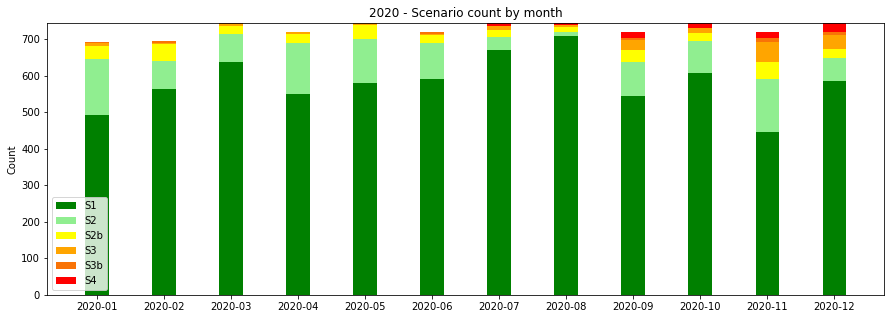

In [37]:
# scenario per month 
data_sc_per_month = df_joined[['datetime_t-0','scenario_t-0']].copy()
data_sc_per_month['month'] = data_sc_per_month['datetime_t-0'].map(lambda x : str(x)[0:7])

data_to_plot = data_sc_per_month.groupby('month')['scenario_t-0'].value_counts().rename('count') \
               .reset_index()

# Replace missing counts by 0
data_to_plot = data_to_plot.append({'month' : '2020-04' , 'scenario_t-0' : 5, 'count': 0},ignore_index=True)
data_to_plot = data_to_plot.append({'month' : '2020-05' , 'scenario_t-0' : 5, 'count': 0},ignore_index=True)
data_to_plot = data_to_plot.append({'month' : '2020-07' , 'scenario_t-0' : 5, 'count': 0},ignore_index=True)
data_to_plot = data_to_plot.append({'month' : '2020-08' , 'scenario_t-0' : 5, 'count': 0},ignore_index=True)

data_to_plot = data_to_plot.append({'month' : '2020-03' , 'scenario_t-0' : 6, 'count': 0},ignore_index=True)
data_to_plot = data_to_plot.append({'month' : '2020-05' , 'scenario_t-0' : 6, 'count': 0},ignore_index=True)



# sort values for plot 
data_to_plot = data_to_plot.sort_values(by=['scenario_t-0','month'])

labels = list(data_to_plot.month.unique())
# Scenario
S1_count = list(data_to_plot.loc[data_to_plot['scenario_t-0'] == 1,'count'].values)
S2_count = list(data_to_plot.loc[data_to_plot['scenario_t-0'] == 2,'count'].values)
S2b_count = list(data_to_plot.loc[data_to_plot['scenario_t-0'] == 3,'count'].values)
S3_count = list(data_to_plot.loc[data_to_plot['scenario_t-0'] == 4,'count'].values)
S3b_count = list(data_to_plot.loc[data_to_plot['scenario_t-0'] == 5,'count'].values)
S4_count = list(data_to_plot.loc[data_to_plot['scenario_t-0'] == 6,'count'].values)

import matplotlib.pyplot as plt
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(15,5))

ax.bar(labels, S1_count, width, label='S1',color='green')
ax.bar(labels, S2_count, width, label='S2',color='lightgreen',bottom=S1_count)
ax.bar(labels, S2b_count, width, label='S2b', color = '#FFFF00',bottom = np.sum([S1_count,S2_count],axis=0))
ax.bar(labels, S3_count, width, label='S3', color='#FFA500',bottom = np.sum([S1_count,S2_count,S2b_count],axis=0))
ax.bar(labels, S3b_count, width, label='S3b', color='#F97306',bottom=np.sum([S1_count,S2_count,S2b_count,S3_count],axis=0))
ax.bar(labels, S4_count, width, label='S4', color='red',bottom=np.sum([S1_count,S2_count,S2b_count,S3_count,S3b_count],axis=0))

ax.set_ylabel('Count')
ax.set_title('2020 - Scenario count by month')
ax.legend()

plt.show()

### Select ensemble training columns

In [38]:
# Loop lists
model_names = ['xgb','dt','mlp','rf']
features = ['speed','cos_wind_dir','sin_wind_dir']
pred_periods = ['1','2','3']

select_columns = dict()
for pred_period in pred_periods:
    select_columns[pred_period] = []
    # Regression columns
    for model_name in model_names:
        for feature in features:
            x = '_'.join([model_name,feature,pred_period])
            select_columns[pred_period] += [x]
    # Scenario proba columns
    for model_name in ['xgb','dt','mlp']:
        feature = 'scenario'
        x = '_'.join([model_name,feature,pred_period])
        select_columns[pred_period] += [x + '_p' + str(i) for i in range(1,7)]
    # Binary proba columns
    for model_name in ['xgb','dt','mlp','rf']:
        feature = 'dangerous'
        x = '_'.join([model_name,feature,pred_period])
        select_columns[pred_period] += [x + '_p' + str(i) for i in range(0,2)]
    # Numtech forecast columns
    select_columns[pred_period] += ['speed_forecast','cos_wind_dir_forecast','sin_wind_dir_forecast','dangerous_forecast']

### Train ensemble models

In [39]:
import pickle
from sklearn.linear_model import LogisticRegression
Y_scenario = df_joined['scenario_t-0']
Y_dangerous = df_joined['dangerous_t-0']
# Columns selection
for pred_period in pred_periods:
    print(len(select_columns[pred_period]))
    X = df_joined[select_columns[pred_period]].copy()
    clf_sc = LogisticRegression(C=1)
    clf_sc = clf_sc.fit(X,Y_scenario)
    pickle.dump(clf_sc,open('../models_09072021/ensemble_models/lr_scenario_' + pred_period + '.p','wb'))
    clf_da = LogisticRegression(C=0.1)
    clf_da = clf_da.fit(X,Y_dangerous)
    pickle.dump(clf_da,open('../models_09072021/ensemble_models/lr_dangerous_' + pred_period + '.p','wb'))
pickle.dump(select_columns, open('../models_09072021/ensemble_models/selected_columns.p','wb'))

42


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


42


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


42


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
